In [1]:
import torch.nn as nn
import torch
import math
import random
from matplotlib import pyplot as plt

In [2]:
random.seed(1001)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

1. Dataset

In [3]:
!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

--2025-11-05 18:44:12--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘input.txt’

input.txt           100%[===================>]   1.06M  --.-KB/s    in 0.008s  

2025-11-05 18:44:13 (138 MB/s) - ‘input.txt’ saved [1115394/1115394]



In [4]:
# read text file
with open('input.txt', 'r') as file:
  text = file.read()
text[:100]

'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou'

In [5]:
len(text)

1115394

In [6]:
# convert text to [ids] according to vocab
vocab = sorted(list(set(text)))
print(vocab)

id_map = {c : i for (i,c) in enumerate(vocab)}
id_map_reverse = {i : c for (i,c) in enumerate(vocab)}
print(id_map)

def encode(text):
  """
    [chars] -> [ids]
  """
  return [id_map[c] for c in text]

def decode(ids):
  """
    [ids] -> string
  """
  return ''.join(id_map_reverse[id] for id in ids)

print(decode(encode("hello")) == "hello")

['\n', ' ', '!', '$', '&', "'", ',', '-', '.', '3', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
{'\n': 0, ' ': 1, '!': 2, '$': 3, '&': 4, "'": 5, ',': 6, '-': 7, '.': 8, '3': 9, ':': 10, ';': 11, '?': 12, 'A': 13, 'B': 14, 'C': 15, 'D': 16, 'E': 17, 'F': 18, 'G': 19, 'H': 20, 'I': 21, 'J': 22, 'K': 23, 'L': 24, 'M': 25, 'N': 26, 'O': 27, 'P': 28, 'Q': 29, 'R': 30, 'S': 31, 'T': 32, 'U': 33, 'V': 34, 'W': 35, 'X': 36, 'Y': 37, 'Z': 38, 'a': 39, 'b': 40, 'c': 41, 'd': 42, 'e': 43, 'f': 44, 'g': 45, 'h': 46, 'i': 47, 'j': 48, 'k': 49, 'l': 50, 'm': 51, 'n': 52, 'o': 53, 'p': 54, 'q': 55, 'r': 56, 's': 57, 't': 58, 'u': 59, 'v': 60, 'w': 61, 'x': 62, 'y': 63, 'z': 64}
True


In [7]:
# train, val set
train = text[:math.floor(0.9*len(text))]
test = text[math.floor(0.9*len(text)):]

print(f"train size: {len(train)}, test size: {len(test)}")

def fetch_batch(mode, batch_size, block_size):
  if mode=='train':
    dataset = train
  else:
    dataset = test
  batch_indices = [random.randint(0, len(dataset)-(block_size+1)) for _ in range(0, batch_size)]
  x = torch.stack([torch.tensor(encode(dataset[index:index+block_size])) for index in batch_indices])
  y = torch.stack([torch.tensor(encode(dataset[index+1:index+block_size+1])) for index in batch_indices])
  return x,y

train size: 1003854, test size: 111540


In [8]:
class SelfAttentionHead(nn.Module):
  def __init__(self, embed_size, head_size):
    super().__init__()
    self.query = nn.Linear(embed_size, head_size)
    self.key = nn.Linear(embed_size, head_size)
    self.value = nn.Linear(embed_size, head_size)

  def forward(self, x):
    # x : batches, block_size, embed_size [B,T,E]
    q = self.query(x) # : B,T,H
    k = self.key(x)
    v = self.value(x)

    attention_scores = (q @ torch.transpose(k, 1,2)) * (k.shape[-1])**(-0.5) # : B, T, T
    tril = torch.tril(torch.ones((k.shape[1], k.shape[1]))).to(device) # : T, T
    masked_attention_scores = attention_scores.masked_fill(tril == 0, float('-inf')) # : B, T, T

    attention_distribution = torch.softmax(masked_attention_scores, dim=-1)
    weighted_vector = attention_distribution @ v # : B,T,H. @ does batch wise matrix multiplication ie does matrix multiplication for each batch elm
    return weighted_vector

In [9]:
class MultiHeadedAttention(nn.Module):
  def __init__(self, n_heads, embed_size, head_size):
    super().__init__()
    self.multiheaded_sa = nn.ModuleList([SelfAttentionHead(embed_size, head_size) for _ in range(n_heads)])
    self.linear = nn.Linear(embed_size, embed_size)
    self.dropout = nn.Dropout(0.2)

  def forward(self, x):
    out = [sa(x) for sa in self.multiheaded_sa]
    out = torch.cat(out, dim=-1) # concatenate info from each head
    out = self.linear(out) # interact with each node and do info exchange amongst heads. : B, T, E
    out = self.dropout(out)
    return out

In [10]:
class FeedForwardNetwork(nn.Module):
  def __init__(self, embed_size, hidden_layer_size):
    super().__init__()
    self.layer1 = nn.Linear(embed_size, hidden_layer_size)
    self.relu = nn.ReLU()
    self.layer2 = nn.Linear(hidden_layer_size, embed_size)
    self.dropout = nn.Dropout(0.2)

  def forward(self, x):
    out = self.layer1(x)
    out = self.relu(out)
    out = self.layer2(out)
    out = self.dropout(out)
    return out

In [11]:
class Block(nn.Module):
  def __init__(self, embed_size, n_heads, head_size, hidden_layer_size):
    super().__init__()
    self.multi_sa = MultiHeadedAttention(n_heads, embed_size, head_size)
    self.feedforward_net = FeedForwardNetwork(embed_size, hidden_layer_size)
    self.layernorm1 = nn.LayerNorm(embed_size)
    self.layernorm2 = nn.LayerNorm(embed_size)

  def forward(self, x):
    x = x + self.multi_sa(x) # residual conn
    x = self.layernorm1(x)
    x = x + self.feedforward_net(x) # residual conn
    x = self.layernorm2(x)
    return x

In [12]:
class Transformer(nn.Module):
  def __init__(self, vocab_size, embed_size, n_heads, head_size, hidden_layer_size, n_blocks, block_size):
    super().__init__()
    self.embed = nn.Embedding(vocab_size, embed_size)
    self.position_embed = nn.Embedding(block_size, embed_size)
    self.blocks = nn.Sequential(*[Block(embed_size, n_heads, head_size, hidden_layer_size) for _ in range(n_blocks)])
    self.linear = nn.Linear(embed_size, vocab_size)
    self.criterion = nn.CrossEntropyLoss()
    self.block_size = block_size
    self.dropout = nn.Dropout(0.2)

    #self.apply(self.init_weights())

  def init_weights(self, module):
      if isinstance(module, nn.Linear):
          torch.nn.init.normal(module.weight, mean=0.0, variance = 0.01)
          if module.Bias is not None:
              torch.nn.init.zeros_(module.bias)
      elif isinstance(module, nn.Embedding):
          torch.nn.init.normal(module.weight, mean=0.0, variance = 0.01)


          
  def forward(self, x, y=None):
    # x : C,T
    embedding = self.embed(x) # : Channels C, Block size T, embedding size E
    position_embedding = self.position_embed(torch.arange(x.shape[1]).to(device)) # : T, E
    x = embedding + position_embedding # makes use of broadcasting over channels for position embedding
    x = self.dropout(x) # dropout for regularization
    out = self.blocks(x)
    logits = self.linear(out)
    if y==None:
      return logits, None

    C,T,E = logits.shape
    logits_temp = logits.view(C*T, E)
    y = y.view(C*T)
    loss = self.criterion(logits_temp, y)
    return logits, loss

  def generate_next_token(self, x):
    logits,_ = self(x)
    # last timestep generated
    logits = logits[:,-1,:] # shape = batches, score over vocab size
    prob = torch.softmax(logits, dim=1)

    # top p sampling
    pred = torch.multinomial(prob, num_samples=1)

    return pred

  def generate(self, x, max_tokens):
    out = x[:,:]
    for _ in range(max_tokens):
      next_word = self.generate_next_token(x)
      x = torch.cat((x, next_word), dim=1) # increase block size
      x = x[:, -self.block_size:] # only retain block size tokens
      out = torch.cat((out, next_word), dim=1)
    return out

In [13]:
(vocab_size, embed_size, n_heads, head_size, hidden_layer_size, n_blocks, block_size) = (65, 384, 6, 64, 1024, 6,256)
transformer = Transformer(vocab_size, embed_size, n_heads, head_size, hidden_layer_size, n_blocks, block_size)
transformer.to(device)
optimizer = torch.optim.AdamW(transformer.parameters(), lr=3e-4)

In [14]:
# generation without training
x = torch.ones((1,1), dtype=torch.long).to(device)
print(decode(transformer.generate(x,1000)[0].tolist()))

 ZsaEEuxcAP'sgLgQSxeq3E3zENNz3SYBSwXrSodu&BtlEtmjSSK-3w3!FFHfA!gQpvPNuZ-O?NHFLuJFRaImeviC'b!bKvVz;cFJ,QouPHWSuEFgktcKE'3:kEai?33zUDlIDq;YmS:;ASdBf;fuEVnPIxKaiyghWdVr?o.YtQA,h!DA;vQgzsZQHmlldMMdAuKcNL-$JHGrIb
hZDNqwouVFuI;YmNWvd? CmLp?zNAXyI;FYK!?,Ipzxy-Hxn$Gs3sKsabk y!bVuNVHbrOBBazm
fhnDrjqLDjFFYVzOKFqOsAJNKx&;--BvxzVIKuujb?Drf
$.$FRoU&X'zYvWhJM3F-UljkUBfjMVbAjfRICtMkSErL'-H:xLFabObka?VEhpD$O$v$GIXkELrSBF
G$iDPUiylqO3hlS.-,Ip?rNu&V:!kFZn!h;lQ.s:ybeyWud!h;esybiFcDv-RIH;zuFO,QEYIdEbP
C3I3MFBouYY.W:QsWUSmIlWAy&aI$HrSocqG&O'LfGKNBYgUhfflFIAMzgrIkJixhloebMli:PnEkQf;wFPd$F$.UmYWiWvdmXJ!StzXFEQYhVLRQOMsc:k,JDsNhrI, a-SmPYlESIJuSfESsHNXJG$ZJihSS I
HbW&Kkx;RQseIsslHyPjkzyNSe.U!i,oPDJrvSBkmZJZoHSiQsYqQTOSkro$gROE?K.Xmn$UYFMqz!iFGNgIZIlonkL.
tje'xYI?uqzNfRW-GhFBfAAQApHlR,IGXWM?SyPCbgDoUHW-lvFW-qsxUfaXfrFyOFbOrbwo-QYXPZffdL!&PlBK,YpFikHWSMAPL
MWECMbBmfRHNY&JJjXQFr
oYcf:royr:;AhxqV
hyUrV?nIY&df'YznUCbHQTOqUK
kQ?l-
ciP;PulRe-NnHxjRHk:h-fuRiX:-yBGFJIIYFvzEF:&qzoSXw:o
GRlYPxENV-;ZIqk-&szuIAJzAk;QYS!Ym

In [15]:
@torch.no_grad()
def performance_measure(batch_size, block_size, n_iters):
  losses = {'train':0, 'val':0}
  transformer.eval()
  for mode in ['train', 'val']:
    for _ in range(n_iters):
      x,y = fetch_batch(mode, batch_size, block_size)
      x = x.to(device)
      y = y.to(device)
      _, loss = transformer(x,y)
      losses[mode] += loss.item()

  transformer.train()
  losses['train'] /= n_iters
  losses['val'] /= n_iters
  return losses

In [16]:
class EarlyStopping:
    def __init__(self, patience, delta):
        self.patience = patience
        self.delta = delta
        self.counter = 0
        self.early_stopping = False
        self.best_val_loss = None

    def __call__(self, model, val_loss):
        if self.best_val_loss is None:
            self.best_val_loss = val_loss
            torch.save(model.state_dict(), "model_weights.pth")
            
        elif val_loss + self.delta < self.best_val_loss:
            self.best_val_loss = val_loss
            torch.save(model.state_dict(), "model_weights.pth")
            self.counter = 0

        else:
            self.counter += 1
            if self.counter > self.patience:
                print("Stopping early")
                self.early_stopping = True
                

In [17]:
earlystopping = EarlyStopping(2, 0.01)

In [18]:
# training loop - added residual conn + layer norm + dropout
n_iters = 5000
iters_after_eval = 500
train_loss = []
batch_size = 64
eval_iters = 200
iteration = 0

for iter in range(n_iters):
    iteration += 1
    x,y = fetch_batch('train', batch_size, block_size)
    x = x.to(device)
    y = y.to(device)

    logits, loss = transformer(x,y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    train_loss.append(loss.item())

    if iter % iters_after_eval == 0:
      losses = performance_measure(batch_size, block_size, eval_iters)
      print(f"Train loss: {losses['train']}, Val loss: {losses['val']}")
      # check for early stopping
      earlystopping(transformer, losses['val'])
      if earlystopping.early_stopping:
          break
    

Train loss: 3.6474017441272735, Val loss: 3.6663515961170194
Train loss: 1.9020925676822662, Val loss: 2.007186497449875
Train loss: 1.5578670543432236, Val loss: 1.7523095732927323
Train loss: 1.425012731552124, Val loss: 1.6343324780464172
Train loss: 1.344227921962738, Val loss: 1.5942774826288224
Train loss: 1.277837483882904, Val loss: 1.5419430738687516
Train loss: 1.227773277759552, Val loss: 1.5203166997432709
Train loss: 1.1892901790142059, Val loss: 1.5191692614555359
Train loss: 1.1498519426584244, Val loss: 1.5164146727323533
Train loss: 1.1143195325136184, Val loss: 1.5141822576522828
Stopping early


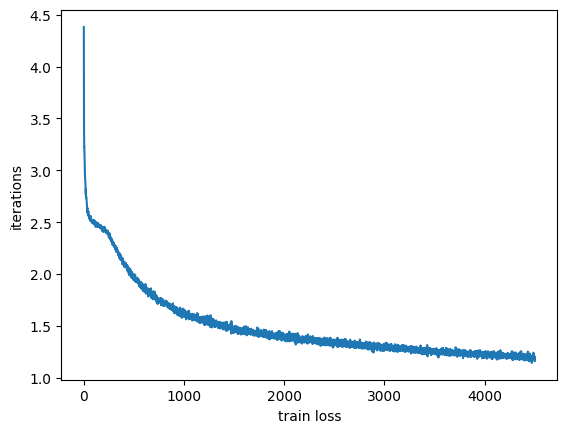

In [19]:
#plt.plot(range(n_iters), train_loss)
plt.plot(range(iteration), train_loss)
plt.xlabel('train loss')
plt.ylabel('iterations')
plt.show()

In [20]:
x = torch.ones((1,1), dtype=torch.long).to(device)
print(decode(transformer.generate(x,10000)[0].tolist()))

 the life 'pothecasa
pardon'st.

HERMIONE:
Besides, you place.

ISABELLA:
I say sure lips too please, &legins trish your follows.

ANGELO:
Be no many fores Christian: I can you cell, when
Master I stine, thisgest your purse to you.

LUCIO:
Prats to be so?

DUKE VINCENTIO:
I lay till we will then; and we skit it with him.

LUCIO:
Pray now, if I had break of it: but me say what is in you:
but I am, make at their prayers.

DUKE VINCENTIO:
Well, sir.

Provost:
Deach, theat do; there is all affly; let the good
that not in his desire not when him now such stoon.

Second Murderer:
nettle him so much his mother. He had nobled point.
Thou art not a falt;
I more great port! that she's as mercy,
Lest me thee and throw monsty greems I have
To 'em with a deright to desire:
But citions thought thou captain feast!
What, which soulst thou never stame height:
Though and we were werem may arm of death?

BUCKINGHAM:
Nay, so, may like up: take me meeting I corry!

BOTHOMAS:
On more, masthough I shall be m

In [21]:
torch.save(transformer.state_dict(), "model_weights.pth")